In [16]:
import json
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import argparse

In [17]:
def load_json_file(filepath: str) -> list[dict] | None:
    if not isinstance(filepath, str):
        return None
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f'Error loading JSON: {e}')
        return None

def flatten_orders(data: list[dict]) -> pd.DataFrame:
    if not data:
        return pd.DataFrame()

    df = pd.DataFrame(data)  # <- You forgot this line

    customer_df = json_normalize(df['customer']).add_prefix('customer_')
    product_df = json_normalize(df['product']).add_prefix('product_')
    shipping_df = json_normalize(df['shipping']).add_prefix('shipping_')

    flat_df = pd.concat([
        df.drop(columns=['customer', 'product', 'shipping']),
        customer_df,
        product_df,
        shipping_df
    ], axis=1)

    return flat_df

def clean_order_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    if df is None:
        return pd.DataFrame()

    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['is_repeat_customer'] = df['customer_id'].duplicated(keep=False)
    
    if 'quantity' not in df or 'product_unit_price' not in df:
        raise ValueError('Missing columns for revenue calculation.')    
    
    df['order_value'] = df['quantity'] * df['product_unit_price']

    return df


def enrich_with_history(df: pd.DataFrame, history: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.merge(history, how='left', on='product_id')
    
    df['margin'] = df['order_value'] - (df['quantity'] * df['base_cost'])

    df['margin'] = df['margin'].round(2)

    return df

def generate_summary(df: pd.DataFrame) -> None:
    print('Top 3 Products by Total Margin:')
    print(df.groupby('product_name')['margin'].sum().sort_values(ascending=False).head(3), end='\n\n')

    print('Top Customers by Total Spend:')
    print(df.groupby('customer_id')['order_value'].sum().sort_values(ascending=False).head(3), end='\n\n')

    repeat_rev = df[df['is_repeat_customer']]['order_value'].sum()
    total_rev = df['order_value'].sum()
    pct = (repeat_rev / total_rev) * 100

    print(f'Revenue from Repeat Customers: €{repeat_rev:.2f} ({pct:.1f}% of total revenue)')

def plot_top_products(df: pd.DataFrame, n=3):
    top_products = (
        df.groupby('product_name')['margin']
        .sum()
        .sort_values(ascending=False)
        .head(n)
    )

    plt.figure(figsize=(8, 5))
    sns.barplot(x=top_products.values, y=top_products.index)
    plt.title(f'Top {n} Products by Margin')
    plt.ylabel('Product Name')
    plt.xlabel('Total Margin (€)')
    plt.tight_layout()
    plt.savefig('top_products_margin.png')

Top 3 Products by Total Margin:
product_name
Surgical Mask        100.0
Hand Sanitizer        40.0
Vitamin C Tablets      8.0
Name: margin, dtype: float64

Top Customers by Total Spend:
customer_id
CUST001    274.0
CUST002    150.0
Name: order_value, dtype: float64

Revenue from Repeat Customers: €274.00 (64.6% of total revenue)


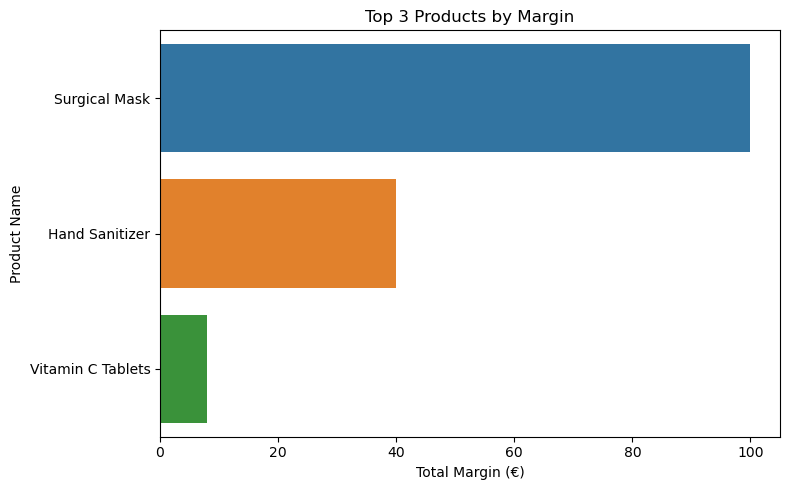

In [18]:
filepath = '../data/orders_nested.json' 
history = '../data/product_history.csv'

data = load_json_file(filepath)      # Loads raw list[dict]
history = pd.read_csv(history)

if data is not None:
    df = flatten_orders(data)        # Flattens the nested JSON
    cleaned_df  = clean_order_df(df)
    enriched_df = enrich_with_history(cleaned_df, history)
    summary = generate_summary(enriched_df)
    plot = plot_top_products(enriched_df)
else:
    print('Data failed to load.')

assert isinstance(data, list)
assert df is not None
assert cleaned_df is not None